In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime, timedelta 
import datetime as dt
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, auc, precision_recall_curve, average_precision_score, 
                             accuracy_score)
from sklearn.model_selection import (GridSearchCV, StratifiedKFold, cross_val_score, 
                                     train_test_split)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from prophet import Prophet
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
import plotly.express as px
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import time 
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
import multiprocessing
import torch.nn.functional as F
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.utils import resample

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel("/kaggle/input/data-new-credit/data1.xlsx")
data = data.dropna()
data['APPLICATION_DATE'] = pd.to_datetime(data['APPLICATION_DATE'])
data['AGREEMENT_DATE'] = pd.to_datetime(data['AGREEMENT_DATE'])
data['UTILIZATION_DATE'] = pd.to_datetime(data['UTILIZATION_DATE'])
data['DIFFERENCE_AA'] = (data['AGREEMENT_DATE'] - data['APPLICATION_DATE']).dt.days
data['DIFFERENCE_AU'] = (data['UTILIZATION_DATE'] - data['AGREEMENT_DATE']).dt.days
data

,APPLICATION_DATE,AGREEMENT_DATE,UTILIZATION_DATE,CNT,DIFFERENCE_AA,DIFFERENCE_AU
0,2023-04-03,2023-04-04,2023-04-04,2,1,0
1,2023-04-03,2023-04-04,2023-04-10,1,1,6
2,2023-04-03,2023-04-05,2023-04-07,1,2,2
3,2023-04-03,2023-04-06,2023-04-06,1,3,0
4,2023-04-03,2023-04-11,2023-04-15,1,8,4
...,...,...,...,...,...,...
3305,2023-06-13,2023-06-15,2023-06-15,14,2,0
3308,2023-06-14,2023-06-14,2023-06-14,20,0,0
3309,2023-06-14,2023-06-14,2023-06-15,12,0,1
3311,2023-06-14,2023-06-15,2023-06-15,63,1,0


In [3]:
def find_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound


lower_bound_AA, upper_bound_AA = find_outliers(data, 'DIFFERENCE_AA')
data['outlier_AA'] = (data['DIFFERENCE_AA'] < lower_bound_AA) | (data['DIFFERENCE_AA'] > upper_bound_AA)

lower_bound_AU, upper_bound_AU = find_outliers(data, 'DIFFERENCE_AU')
data['outlier_AU'] = (data['DIFFERENCE_AU'] < lower_bound_AU) | (data['DIFFERENCE_AU'] > upper_bound_AU)

print(f"Outliers in DIFFERENCE_AA: {len(data[data['outlier_AA']])}")
print(f"Outliers in DIFFERENCE_AU: {len(data[data['outlier_AU']])}")

Outliers in DIFFERENCE_AA: 174
Outliers in DIFFERENCE_AU: 165


In [4]:
# Filter rows 
data_filtered = data[(data['DIFFERENCE_AA'] >= 0) & (data['DIFFERENCE_AA'] <= 45) &
                     (data['DIFFERENCE_AU'] >= 0) & (data['DIFFERENCE_AU'] <= 41)]

print("Number of rows after filtering:", data_filtered.shape[0])

fig_AA_filtered = px.box(data_filtered, y='DIFFERENCE_AA', title='Box Plot of Filtered Difference AA',
                        labels={'DIFFERENCE_AA': 'Difference AA (Days)'})

fig_AA_filtered.update_traces(marker=dict(size=8,color='red', line=dict(width=1, color='DarkSlateGrey')))
fig_AA_filtered.show()

fig_AU_filtered = px.box(data_filtered, y='DIFFERENCE_AU', title='Box Plot of Filtered Difference AU',
                        labels={'DIFFERENCE_AU': 'Difference AU (Days)'})

fig_AU_filtered.update_traces(marker=dict(size=8, color='red', line=dict(width=1, color='DarkSlateGrey')))
fig_AU_filtered.show()

Number of rows after filtering: 2791


In [5]:
df = data_filtered.copy()
df.drop(columns=["outlier_AA", "outlier_AU"], inplace = True)
df

,APPLICATION_DATE,AGREEMENT_DATE,UTILIZATION_DATE,CNT,DIFFERENCE_AA,DIFFERENCE_AU
0,2023-04-03,2023-04-04,2023-04-04,2,1,0
1,2023-04-03,2023-04-04,2023-04-10,1,1,6
2,2023-04-03,2023-04-05,2023-04-07,1,2,2
3,2023-04-03,2023-04-06,2023-04-06,1,3,0
4,2023-04-03,2023-04-11,2023-04-15,1,8,4
...,...,...,...,...,...,...
3305,2023-06-13,2023-06-15,2023-06-15,14,2,0
3308,2023-06-14,2023-06-14,2023-06-14,20,0,0
3309,2023-06-14,2023-06-14,2023-06-15,12,0,1
3311,2023-06-14,2023-06-15,2023-06-15,63,1,0


In [6]:
def create_features(data):
    # date differences
    data['DIFFERENCE_AA'] = (data['AGREEMENT_DATE'] - data['APPLICATION_DATE']).dt.days
    data['DIFFERENCE_AU'] = (data['UTILIZATION_DATE'] - data['AGREEMENT_DATE']).dt.days
    data['UTILIZATION_DAY_OF_WEEK'] = pd.to_datetime(data['UTILIZATION_DATE']).dt.dayofweek
    # Categorical features based on dates
    data['application_day_of_week'] = data['APPLICATION_DATE'].dt.dayofweek
    data['application_month'] = data['APPLICATION_DATE'].dt.month
    data['agreement_day_of_week'] = data['AGREEMENT_DATE'].dt.dayofweek
    data.rename( columns= {"APPLICATION_DATE": "date"}, inplace = True)
    data.drop(columns = [ 'AGREEMENT_DATE', 'UTILIZATION_DATE'], inplace = True)
    return data

In [7]:
df = create_features(df)
df

,date,CNT,DIFFERENCE_AA,DIFFERENCE_AU,UTILIZATION_DAY_OF_WEEK,application_day_of_week,application_month,agreement_day_of_week
0,2023-04-03,2,1,0,1,0,4,1
1,2023-04-03,1,1,6,0,0,4,1
2,2023-04-03,1,2,2,4,0,4,2
3,2023-04-03,1,3,0,3,0,4,3
4,2023-04-03,1,8,4,5,0,4,1
...,...,...,...,...,...,...,...,...
3305,2023-06-13,14,2,0,3,1,6,3
3308,2023-06-14,20,0,0,2,2,6,2
3309,2023-06-14,12,0,1,3,2,6,2
3311,2023-06-14,63,1,0,3,2,6,3


# Models

In [8]:
# date index
date_index = df['date']
dates = date_index[0:2791]
# Convert each date to a string in the '%Y-%m-%d' format
dates_list = [date.strftime('%Y-%m-%d') for date in dates]

In [9]:
df['date'] = pd.to_datetime(df['date'])  # Ensure the date column is in datetime format
df.set_index('date', inplace=True)  # Set the date as the index
df.sort_index(inplace=True)

# train, validation, and test splits
train_size = int(len(df) * 0.7)
validation_size = int(len(df) * 0.15)
test_size = len(df) - train_size - validation_size

train = df[:train_size]
validation = df[train_size:train_size + validation_size]
test = df[train_size + validation_size:]

# Features and target
X_train = train.drop('CNT', axis=1)
y_train = train['CNT']
X_validation = validation.drop('CNT', axis=1)
y_validation = validation['CNT']
X_test = test.drop('CNT', axis=1)
y_test = test['CNT']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)


# Random Forest

RMSE: 1.0293771400187015
RMSE: 1.2289489254024668
RMSE: 1.2480633987248442
RMSE: 2.4109858500617145
RMSE: 5.260923911118771


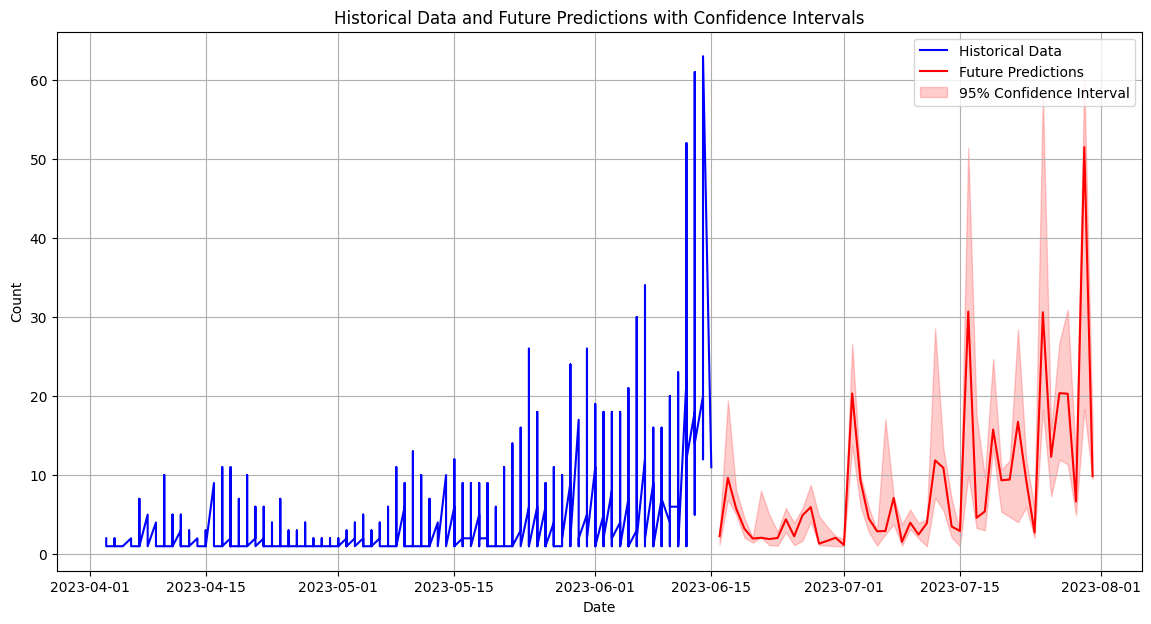

In [10]:
#Define features and target
X = df.drop('CNT', axis=1)  # Features
y = df['CNT']  # Target

# Define time series split
tscv = TimeSeriesSplit(n_splits=5)

# Train and evaluate model
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rmse}")

# Train on the full dataset
model.fit(X, y)

# Prepare future dates
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), end='2023-07-31', freq='D')
future_X = X.iloc[-len(future_dates):].copy()  # Use the last available features for predictions

# Bootstrapping
n_iterations = 1000
predictions = []

for i in range(n_iterations):
    X_resample, y_resample = resample(X, y)
    model.fit(X_resample, y_resample)
    future_pred = model.predict(future_X)
    predictions.append(future_pred)

# Convert predictions to DataFrame
predictions_df = pd.DataFrame(predictions).T

# Calculate percentiles for confidence intervals
lower_bound = predictions_df.quantile(0.025, axis=1)
upper_bound = predictions_df.quantile(0.975, axis=1)

# Create DataFrame for future predictions
future_df = pd.DataFrame({'CNT_Predicted': model.predict(future_X),
                          'Lower_CI': lower_bound.values,
                          'Upper_CI': upper_bound.values},
                         index=future_dates)

# Plot historical data and predictions
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['CNT'], label='Historical Data', color='blue')
plt.plot(future_df.index, future_df['CNT_Predicted'], label='Future Predictions', color='red')
plt.fill_between(future_df.index, future_df['Lower_CI'], future_df['Upper_CI'], color='red', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Historical Data and Future Predictions with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END c

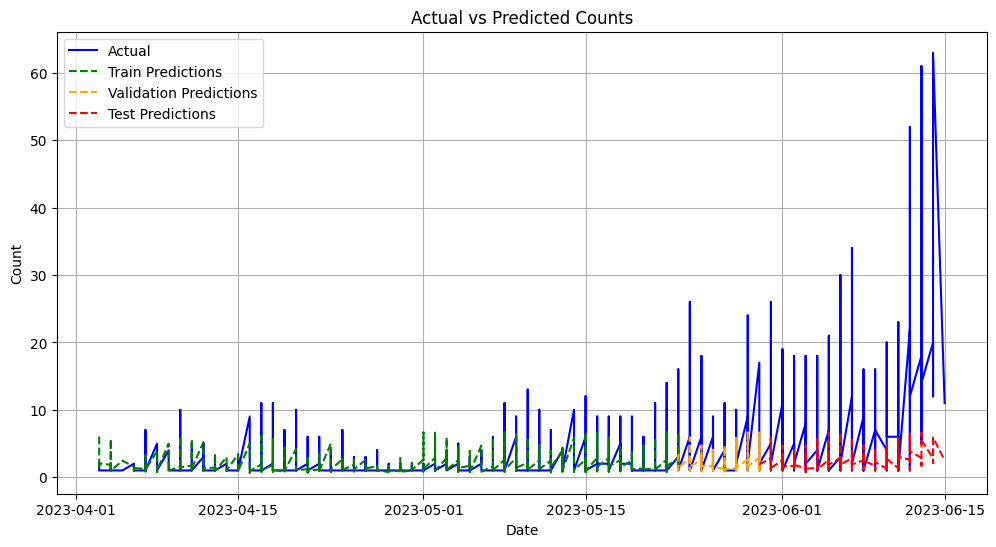

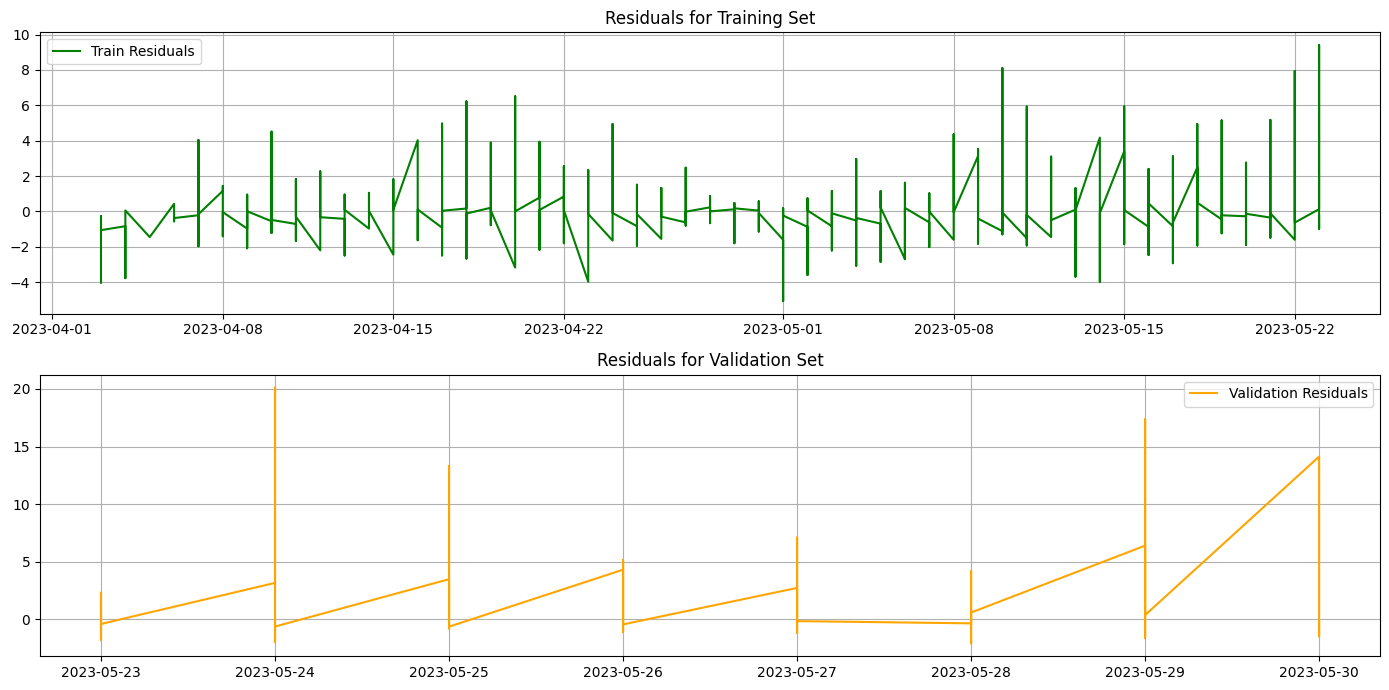

In [11]:
train_size = int(len(df) * 0.7)
validation_size = int(len(df) * 0.15)
test_size = len(df) - train_size - validation_size

train = df[:train_size]
validation = df[train_size:train_size + validation_size]
test = df[train_size + validation_size:]

X_train = train.drop('CNT', axis=1)
y_train = train['CNT']
X_validation = validation.drop('CNT', axis=1)
y_validation = validation['CNT']
X_test = test.drop('CNT', axis=1)
y_test = test['CNT']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

# Define and train the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_

# Make predictions
y_train_pred = best_model.predict(X_train_scaled)
y_validation_pred = best_model.predict(X_validation_scaled)
y_test_pred = best_model.predict(X_test_scaled)

# Evaluate the model
def evaluate_model(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{name} Evaluation:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R²): {r2:.2f}\n")

evaluate_model(y_train, y_train_pred, "Train")
evaluate_model(y_validation, y_validation_pred, "Validation")
evaluate_model(y_test, y_test_pred, "Test")

# Bootstrap confidence intervals
def bootstrap_ci(y_true, y_pred, n_bootstrap=1000, alpha=0.05):
    boot_means = []
    for _ in range(n_bootstrap):
        indices = resample(range(len(y_true)))
        boot_y_true = y_true.iloc[indices]
        boot_y_pred = y_pred[indices]
        boot_means.append(np.mean(boot_y_pred - boot_y_true))
    lower_bound = np.percentile(boot_means, 100 * alpha / 2)
    upper_bound = np.percentile(boot_means, 100 * (1 - alpha / 2))
    return lower_bound, upper_bound

# Calculate confidence intervals
lower_bound, upper_bound = bootstrap_ci(pd.Series(y_test), y_test_pred)
print(f"95% Confidence Interval for Mean Prediction Error: ({lower_bound:.2f}, {upper_bound:.2f})")

# Plot historical and predicted data
train['Predicted_CNT'] = y_train_pred
validation['Predicted_CNT'] = y_validation_pred
test['Predicted_CNT'] = y_test_pred

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['CNT'], label='Actual', color='blue')
plt.plot(train.index, train['Predicted_CNT'], label='Train Predictions', color='green', linestyle='--')
plt.plot(validation.index, validation['Predicted_CNT'], label='Validation Predictions', color='orange', linestyle='--')
plt.plot(test.index, test['Predicted_CNT'], label='Test Predictions', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Actual vs Predicted Counts')
plt.legend()
plt.grid(True)
plt.show()

# Plot residuals
train['Residuals'] = y_train - y_train_pred
validation['Residuals'] = y_validation - y_validation_pred
test['Residuals'] = y_test - y_test_pred

plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(train.index, train['Residuals'], label='Train Residuals', color='green')
plt.title('Residuals for Training Set')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(validation.index, validation['Residuals'], label='Validation Residuals', color='orange')
plt.title('Residuals for Validation Set')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()